<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Mobile Phone Review Analysis

## Context

The product companies can utilize the detailed review comments to gather insights from the end user. Most of the products are sold via e-commerce sites like Flipkart or Amazon where customers can buy a product and give their review about the product on the web site. 
Product managers can identify the relevant reviews from the website and run a sentiment analysis tool to understand what the sentiments of the customer are. Based on their sentiments, they can identify what users think of the current product. Are they happy? Discontent? 
They can also come up with a document that lists the features, the team needs to focus on for making the product better. 

## Objective

Given the review data rating label, we will try to get insights about various brands and their ratings using text analytics and build a model to predict the rating and overall sentiment. 


### Package version

- tensorflow==2.3.0
- scikit-learn==0.22.2.post1
- pandas==1.0.5
- numpy==1.18.5
- matplotlib==3.2.2
- google==2.0.3

### Data Dictionary 

product_data.csv - contains product details
- 'asin',  - Product ASIN
- 'brand', - Product Brand
- 'title', - Product Title
- 'url',  - Product URL
- 'image', - Product Image URL
- 'rating',- Product Avg. Rating
- 'reviewUrl' - Product Review Page URL
- 'totalReviews' - Product Total Reviews
- ‘price’ - Product Price ($)
- ‘originalPrice’ - Product Original Price ($)
 
reviews.csv  - contains user review details
 
- 'asin' - Product ASIN
- 'name' - Reviewer Name
- 'rating' - Reviewer Rating (scale 1 to 5)
- 'date'  - Review Date
- 'verified' - Valid Customer
- 'title'  - Review Title
- 'body'  - Review Content
- 'helpfulVotes  - Helpful Feedbacks


## Table of Content

1. Import Libraries

2. Setting options

3. Read Data

4. Data Analysis and EDA

5. Text preprocessing and Vectorization

6. Model building

7. Conclusion and Interpretation

## 1. Import Libraries

Let us start by mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let us check for the version of installed tensorflow.

In [2]:
# used to supress display of warnings
import warnings

# os is used to provide a way of using operating system dependent functionality
# We use it for setting working folder
import os

# Pandas is used for data manipulation and analysis
import pandas as pd 

# Numpy is used for large, multi-dimensional arrays and matrices, along with mathematical operators on these arrays
import numpy as np

# Matplotlib is a data visualization library for 2D plots of arrays, built on NumPy arrays 
# and designed to work with the broader SciPy stack
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot

# Seaborn is based on matplotlib, which aids in drawing attractive and informative statistical graphics.
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)

2.5.0


The installed version of tensorflow is 2.5.0.


## 2. Setting Options

In [3]:
# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

## 3. Read Data

### 3.1 Read the provided CSVs and check 5 random samples and shape to understand the datasets

In [4]:
# Folder location on google drive where the data files are kept. 
path = '/content/drive/MyDrive/Colab Notebooks/Great-Learning-AIML/Internal Lab - Statistical NLP/'

# Loading product data to dataframe.
product_df = pd.read_csv(path + 'product_data.csv')

# Printing loaded dataframe shape. 
product_df.shape

(720, 10)

Loading Product CSV and checking the shape of product dataframe to confirm the load was successful. As we can see above product dataframe has 720 rows and 10 columns.  

In [5]:
# Eye balling dataframe by printing few random rows of data.
product_df.sample(2)

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
573,B07QCCW5KB,Xiaomi,"Xiaomi Redmi 7 32Gb+3GB RAM 6.26"" HD+ LTE Fact...",https://www.amazon.com/Xiaomi-Factory-Unlocked...,https://m.media-amazon.com/images/I/71FVXlimMT...,4.4000000,https://www.amazon.com/product-reviews/B07QCCW5KB,146,149.0000000,0.0000000
444,B07H445L82,Samsung,Samsung SM-J737VZKAVZW Galaxy J7 V 16GB (2018)...,https://www.amazon.com/Samsung-SM-J737VZKAVZW-...,https://m.media-amazon.com/images/I/51fctx5FFP...,3.6000000,https://www.amazon.com/product-reviews/B07H445L82,15,88.0000000,93.9900000


As seen above:

1) Some of the columns like 'url', 'image' and 'reviewUrl' are not usefull from the sentiment analysis, so we will drop those going further.

2) Column 'asin' is product identifier and will be used for joining rows from review dataframe.

3) Remaining column 'brand', 'rating', 'totalReviews' and 'price' will be used further in univeriate and bi-variate analysis.  



In [6]:
# Loading product reviews data to review dataframe.
review_df = pd.read_csv(path + 'reviews.csv')

# Printing loaded dataframe shape. 
review_df.shape

(67986, 8)

Loading Review data from CSV and checking the shape of review dataframe to confirm the load was successful. As we can see above review dataframe has 67986 rows and 8 columns.


In [7]:
# Eyeballing few rows of review dataframe.
review_df.head(2)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0000000
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0000000


As seen above:

1) Main column for the sentiment analysis will body.

2) Column 'asin' is product identifier and will be used for joining rows from product dataframe.

3) Othe column 'rating', 'verified', 'title' and 'helpfullVotes' will be used further in univeriate and bi-variate analysis.  

## 4.  Data Analysis and EDA

### 4.1 Drop unnecessary columns like 'url', 'image' from the product_data

In [8]:
# Printing list of all columns in product dataframe. 
product_df.columns

Index(['asin', 'brand', 'title', 'url', 'image', 'rating', 'reviewUrl',
       'totalReviews', 'price', 'originalPrice'],
      dtype='object')

In [9]:
# Print shape for product dataframe before dropping unnecessary columns.
print('Product df shape before dropping columns', product_df.shape)

# Dropping Columns and storing result in product_dff.
product_dff = product_df.drop(['url', 'reviewUrl', 'image'], axis=1)

# Print shape for product dataframe after dropping columns.
print('Product df shape after dropping columns', product_dff.shape)

Product df shape before dropping columns (720, 10)
Product df shape after dropping columns (720, 7)


As we can see above after removing the unnecessary columns now product dataframe is left with 7 columns. There is now change in rows count.

### 4.2 Check statistical summary of both datasets. Note:- Include both numerical and object type columns.

In [10]:
# Statistical summary for numerical fields in product dataframe. 
product_dff.describe()

,rating,totalReviews,price,originalPrice
count,720.0000000,720.0000000,720.0000000,720.0000000
mean,3.7137500,105.6791667,234.9489306,63.6907778
std,0.7160138,167.6011014,200.0084407,172.4053696
min,1.0000000,1.0000000,0.0000000,0.0000000
25%,3.3000000,7.0000000,97.5125000,0.0000000
50%,3.8000000,32.0000000,188.9750000,0.0000000
75%,4.1000000,122.2500000,336.7250000,0.0000000
max,5.0000000,983.0000000,999.9900000,999.9900000


Summary:

1) 'rating' column is actually a categorical column with numeric type with min value as 1 and maximum value as 5. Also, mean is less than median which show the distribution is marginally left skewed.

2) For column 'totalReviews' and 'price' data suggest right skew and Also, 'price' column having minimum value of 0 which we need to further investigate.

3) All numeric column has 720 which means there is no missing data in these columns.

4) We can also see outliers in column 'totalReviews', 'price' and 'originalPrice'


In [11]:
# Statistical summary for non-numerical fields in product dataframe. 
product_dff.describe(include='O')

,asin,brand,title
count,720,716,720
unique,720,10,718
top,B0722NN2RG,Samsung,"Apple iPhone 6S, 64GB, Rose Gold - For AT&T / ..."
freq,1,346,2


Summary:

1) 'asin' column is a unique identifier for product. This is confirmed by count and unique value, both being 720.

2) 'brand' column has 716 rows and have 10 unique brands with Samsung with highest occurrence.


In [12]:
# Statistical summary for numerical fields in product review dataframe. 
review_df.describe()

,rating,helpfulVotes
count,67986.0000000,27215.0000000
mean,3.8079163,8.2296895
std,1.5829058,31.9548772
min,1.0000000,1.0000000
25%,3.0000000,1.0000000
50%,5.0000000,2.0000000
75%,5.0000000,5.0000000
max,5.0000000,990.0000000


Summary:

1) As in product dataframe, 'rating' column is actually a categorical column with numeric type with min value as 1 and maximum value as 5. Also in reviews dataframe, mean is less than median which show the distribution is left skewed.

2) 'helpfulVotes' column rows count is approx 27000 which is less than half of review dataframe rows and also, maximum value for the column is more than 100 times to the mean value suggest outliers.


In [13]:
# Statistical summary for non-numerical fields in product review dataframe.
review_df.describe(include='O')

,asin,name,date,title,body
count,67986,67984,67986,67972,67965
unique,720,47323,2983,41489,59811
top,B00F2SKPIM,Amazon Customer,"December 11, 2019",Five Stars,Good
freq,981,6507,234,6043,303


Summary:

1) 'asin' column is a unique identifier for product. For all rows in product reviews dataframe it has 720 unique value which is same as product rows count.

2) For both 'title' and 'body' column good amount of data avaible. There are less than 20 rows of missing values in both the columns.

### 4.3 From the above statistical summary, write inferences like count of unique products, top brand, top title, range of rating, price range, etc

Summary:

1) 'asin' column is a unique identifier for product and has 720 unique values in both the datasets. There are 720 rows and 720 unique values in product data and in review there are 67986 rows and 720 unique rows.

2) 'rating' column in both dataframe is actually a identifier column with numeric type with min value as 1 and maximum value as 5. There are approx. 50% rows for 5 Start ratings in review dataframe. Mean value is arount 3.7 to 3.8 in both datasets. This suggest prediction will be bais to Postive reviews.

3) 'brand' column from product dataset confirm there 10 unique brands within the data and Also brand Samsung is with highest occurrence with 346 product rows out of total of 720 rows.

4) For 'price' column  in product table we observe high numbers for minimum value of 0 which we need to further investigate.

5) We can also see outliers in column 'totalReviews', 'price' and 'originalPrice' from product data and similarly in 'helpfulVotes' column from review data.

6) Some columns in review dataset are having null and na values. 



### 4.4 Analyze the distribution of ratings and other categorical features like brand, etc

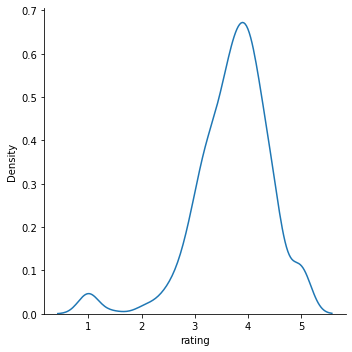

In [14]:
# Printing 'rating' column distribution. 
sns.displot(data=product_dff, x='rating', kind='kde');

As we can see above the distribution plot shows multiple peaks. This is due to cluster for low rating and other cluster of 3-4 ratings.
 

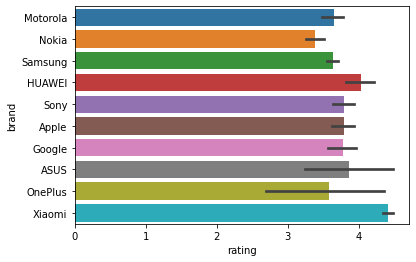

In [15]:
# Ploting brand wise ratings.
sns.barplot(data=product_dff, x=product_dff.rating, y='brand');

As we can see from above bar chart Xiaomi is with the highest rating followed by Huawei and Asus.

### 4.5 Display average rating per brand

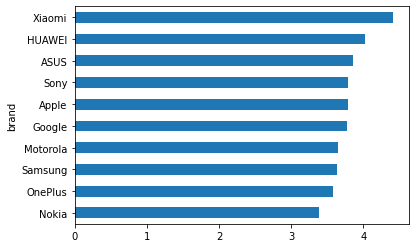

In [16]:
# Calculating and plotting average rating per brand using bar chart
product_dff.groupby(by='brand')['rating'].mean().sort_values().plot(kind='barh');

Again we can see from above bar chart Xiaomi has is topping the list with highest average rating followed by Huawei and Asus.

### 4.6 Display average price per brand

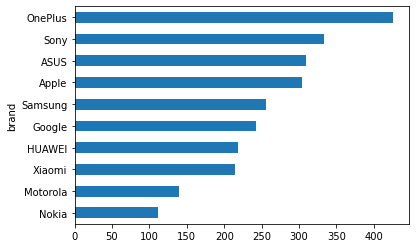

In [17]:
# Calculating and plotting average price per brand using bar chart
product_dff.groupby(by='brand')['price'].mean().sort_values().plot(kind='barh');

As we can see from above bar chart OnePlus has highest average price followed by Sony and Asus.

### 4.7 Display average 'totalReviews' per brand

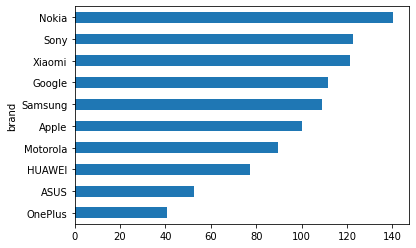

In [18]:
# Calculating and plotting average totalReviews per brand using bar chart
product_dff.groupby(by='brand')['totalReviews'].mean().sort_values().plot(kind='barh');

As we can see from above bar chart Nokia top the list for the total reviews per brand followed by Sony and Xiaomi.

### 4.8 Merge two datasets using 'asin' and check the shape of the final dataset

In [19]:
# Printing shape of review(left) dataset
print("Review Dataframe shape : ", review_df.shape)

Review Dataframe shape :  (67986, 8)


In [20]:
# Merging and Joining review and product dataframe and storing the result in df.
df = pd.merge(review_df, product_dff, how='left', left_on='asin', right_on='asin')

# Printing shape for merged dataset.
print("Merged Dataframe shape : ", df.shape)

Merged Dataframe shape :  (67986, 14)


As seen above after merging product and review the new joined dataset df has same number of rows of left table that is review. After merge the no of rows remain at 67986 but columns has increased to 14.

In [21]:
# Eyeballing merged dataframe.
df.head(2)

,asin,name,rating_x,date,verified,title_x,body,helpfulVotes,brand,title_y,rating_y,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0000000,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,3.0000000,14,0.0000000,0.0000000
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0000000,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,3.0000000,14,0.0000000,0.0000000


As we can see above, after merging the columns with same names in both dataframes are suffixed with x and y. x for the review (left) and y for product (right). We will rename these columns next section.

### 4.9 Rename important features with appropriate names.
Imortant features - "rating_x": "user_rating", "title_x": "review_title", "title_y": "item_title", "rating_y": "overall_rating"

In [22]:
# Renaming x, y suffixed columns to user friendly names.
df.rename(columns={ "rating_x": "user_rating", "title_x":"review_title", 
                   "title_y":"item_title", "rating_y":"overall_rating" }, inplace=True )

Above code will rename the suffixed columns to user friendly and more meaning full name.

In [23]:
# Printing a row from merged dataframe after renaming columns
df.head(1)

,asin,name,user_rating,date,verified,review_title,body,helpfulVotes,brand,item_title,overall_rating,totalReviews,price,originalPrice
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0000000,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,3.0000000,14,0.0000000,0.0000000


Above output confirmed the suffixed columns in merged dataframe df has been renamed to user friendly names.

### 4.10 Select rows having verified reviews and check the shape of the final dataset

In [24]:
# Printing value counts for 'verified' field.
df.verified.value_counts()

True     61225
False     6761
Name: verified, dtype: int64

The reviews with varified field value as True is 61225 and value as False is 6761.


In [25]:
# Dropping rows whose verified value is false.
dff = df[df.verified==True]

# Printing shape for verified reviews.
print("Verified reviews dataframe shape : ", dff.shape)

Verified reviews dataframe shape :  (61225, 14)


Now the product reviews dataset has varified reviews only.

### 4.11 Check the number of reviews for various brands and report the brand that have highest number of reviews

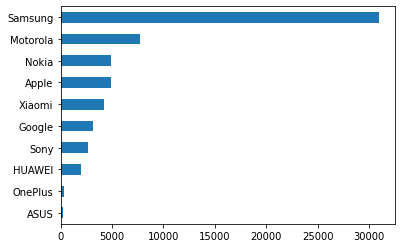

In [26]:
# Calculating and plotting number of review brand wise.
dff['brand'].value_counts().sort_values().plot(kind='barh');

As we can see clearly from above report the highest number of reviews are there for Samsung brand, followed by Motorola  and Nokia.

### 4.12 Drop irrelevant columns and keep important features like 'brand','body','price','user_rating','review_title' for further analysis

In [27]:
# Removing more irrelevent columns and storing the result in df_final.
df_final = dff[['brand','body','price','user_rating','review_title']]

# Printing shape for final df.
print("Final dataframe shape : ", df_final.shape)

Final dataframe shape :  (61225, 5)


In [28]:
# Printing a row from df_final using head function.
df_final.head(1)

,brand,body,price,user_rating,review_title
14,Motorola,DON'T BUY OUT OF SERVICE,49.9500000,1,Stupid phone


As stated we have further trimmed the dataset by keeping the following columns:

'brand', 'body', 'price', 'user_rating' & 'review_title' 

Also confirmed the remaining columns by calling head function on df_final.

### 4.13 Perform univariate analysis. Check distribution of price, user_rating

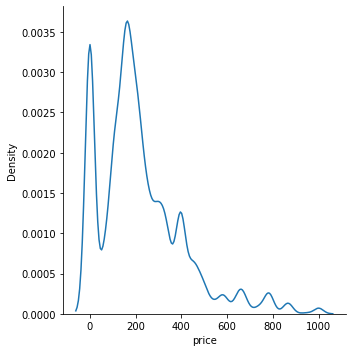

In [29]:
# Printing distribution of price field in df_final.
sns.displot(data=df_final, x='price', kind='kde');

As we can see from the above chart their are multiple peaks or cluster for price in reviews datasets. There are substantial number of rows for which price value is 0. This need to be understood feom buisness person for the reason where price is 0. For now we are going ahead with those rows.

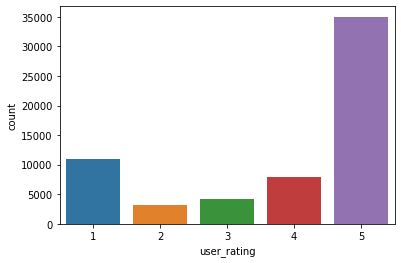

In [30]:
# Printing counts chart of user ratings field in df_final.
sns.countplot(df_final['user_rating']);

As we can see from the count plots the highest numnbers of reviews are for 5 rating followed by 1 rating, 4 rating, 3 rating & 2 rating. 

### 4.14 Create a new column called "sentiment". It should have value as 1 (positive) if the user_Rating is greater than 3, value as 0 (negative) if the user_Rating <= 3

In [31]:
# Creating new column 'sentiment' and storing the clubbed ratings.
df_final['sentiment'] = df_final['user_rating'].apply(lambda x: 1 if x>3 else 0)

The sentiment column will have value 1 (positive) is user rating is greater than 3 and 0 (negitive) if user rating is less than or equal to 3. We have achived this using lambda function.

### 4.15 Check frequency distribution of the 'sentiment'

In [32]:
# Printing value counts for sentiment column.
df_final['sentiment'].value_counts()

1    42939
0    18286
Name: sentiment, dtype: int64

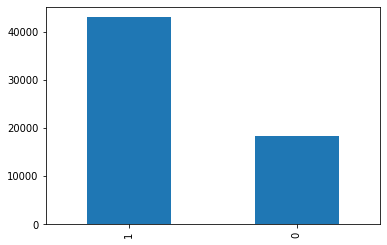

In [33]:
# Plotting value counts for sentiment column to bar chart.
df_final['sentiment'].value_counts().plot(kind='bar');

As we can see above their is lot of bias towards the positive class. Positive class is still two and half times more than the negitive class. This will have impact on the clasification results as it will be more bias towards the positive class.

### 4.16 Perform bivariate analysis. Check correlation/crosstab between features and write your inferences.

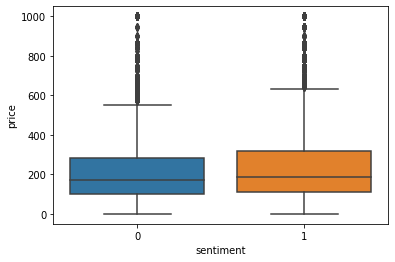

In [34]:
# Cheacking relationship between sentiments and price using box plot.
sns.boxplot(x=df_final['sentiment'], y=df_final['price']);

For both the classes positive and negitve the results are same. This clearly say pirce is not able to clearly seperate the sentiments and not a strong feature for prediting sentiment.

In [35]:
# Checking the bi-variate analysis for brand with sentiment.
pd.crosstab(df_final['brand'], df_final['sentiment']).apply(lambda r: r/r.sum(), axis=1)

sentiment,0,1
brand,,
ASUS,0.3349515,0.6650485
Apple,0.3336751,0.6663249
Google,0.3196333,0.6803667
HUAWEI,0.1812779,0.8187221
Motorola,0.2877884,0.7122116
Nokia,0.3903239,0.6096761
OnePlus,0.1480263,0.8519737
Samsung,0.3062218,0.6937782
Sony,0.3266444,0.6733556


For all brands the positive reviews are nearly twice as the negitive reviews. For Xiaomi, OnePlus and Huawei positive reviews are nearly 4-5 times more than the negitive reports.

## 5. Text Preprocessing and Vectorization

We will analyze the 'body' and 'review_title' to gain more understanding.

We will peform the below tasks

- Convert the text into lowercase
- Remove punctuation
- Remove stopwords (English, from nltk corpus)
- Remove other keywords like "phone" and brand name

### 5.1 Change the datatype of the 'body' column to 'str' and convert it into lowercase. Print any two samples and check the output.

In [36]:
# Taking the bodu column value and converting it to lower and storing in keywords column.
df_final['keywords'] = df_final['body'].str.lower()

# Eyeballing the keywords column by printing first five rows.
df_final['keywords'].head()

14                             don't buy out of service
17    1 star because the phones locked so i have to ...
18    the product has been very good. i had used thi...
21    i bought this phone to replace an lg phone tha...
22    i purchased this phone for my at&t phone repla...
Name: keywords, dtype: object

Above code has transformed the bodu column values to lowercase and storing the result in new column keywords.

### 5.2 Remove punctuations from the lowercased 'body' column and display at least two samples.

In [37]:
# Method one: Using string.punctuation from string library.
import string
# Displaying first five rows of keywords column where punctuation have been removed using method 1.
df_final['keywords'].str.translate(str.maketrans('', '', string.punctuation)).head()

14                              dont buy out of service
17    1 star because the phones locked so i have to ...
18    the product has been very good i had used this...
21    i bought this phone to replace an lg phone tha...
22    i purchased this phone for my att phone replac...
Name: keywords, dtype: object

In [38]:
# Method one: Using RegEx.
# Using RegEx finding all matches that doesnot belongs to 
# alphabets and digits, replacing it with empty string.
df_final['keywords'] = df_final['keywords'].str.replace('[^\w\s]','')

In [39]:
# Displaying first five rows of keywords column where punctuation have been removed using Regex.
df_final['keywords'].head()

14                              dont buy out of service
17    1 star because the phones locked so i have to ...
18    the product has been very good i had used this...
21    i bought this phone to replace an lg phone tha...
22    i purchased this phone for my att phone replac...
Name: keywords, dtype: object

As we can see the first five rows displayed for both methods has same result. We have gone ahead with RegEx as a matter of personal choice and due to flexibilty provided by RegEx pattern.

### 5.3 Remove stop words from the above pre-processed 'body' column and display at least two samples.

In [40]:
# Importing nltk library.
import nltk
# Importing stopwords from nltk corpus.
from nltk.corpus import stopwords

# Downloading stopwords file.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
# Reading english language default stop words and storing it into local variable.
stop_words = set(stopwords.words('english'))

# Converting keywords column to string type
df_final['keywords'] = df_final['keywords'].astype('string')

# Fixing na replacing with empty string
df_final['keywords'] = df_final['keywords'].fillna("")

# Printing df_final column info to confirm keywords column dtype is string.
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61225 entries, 14 to 67984
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         61078 non-null  object 
 1   body          61207 non-null  object 
 2   price         61225 non-null  float64
 3   user_rating   61225 non-null  int64  
 4   review_title  61211 non-null  object 
 5   sentiment     61225 non-null  int64  
 6   keywords      61225 non-null  string 
dtypes: float64(1), int64(2), object(3), string(1)
memory usage: 6.2+ MB


In [42]:
# Removing stopwords from keywords.  
df_final['keywords'] = df_final['keywords'].apply(
    lambda words: ' '.join(word for word in words.split() if word not in stop_words))

In [43]:
# Printing top 5 rows of keywords column to verfiy if stopwords have been removed.
df_final['keywords'].head()

14                                     dont buy service
17      1 star phones locked pay additional fees unlock
18    product good used cell phone one projects work...
21    bought phone replace lg phone didnt like expec...
22    purchased phone att phone replacement even tho...
Name: keywords, dtype: object

### 5.4 Apply lemmatisation on the above preprocessed text and display a few samples

In [44]:
# Downloading wordnet for WordNetLemmatizer from nltk.
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
# Creating instance of whitespace Tokenizer for creating token from keywords.
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

# Creating instance of WordNetLemmatizer.
lemmatizer = nltk.stem.WordNetLemmatizer()

In [46]:
# Defining funtion which will create token and lemmatize the same.
def lemmatize_text(text):
  return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [47]:
# Applying lemmatize_text on keywords column of df_final and store the result in
# 'lemm' column.
df_final['lemm'] = df_final['keywords'].apply(lemmatize_text)

In [48]:
# Printing 'lemm' column value for top 5 row to see lemmatize tokens. 
df_final['lemm'].head()

14                                 [dont, buy, service]
17    [1, star, phone, locked, pay, additional, fee,...
18    [product, good, used, cell, phone, one, projec...
21    [bought, phone, replace, lg, phone, didnt, lik...
22    [purchased, phone, att, phone, replacement, ev...
Name: lemm, dtype: object

### 5.5 Check most common and rare words in the processed text
- We can also write a function to check word frequency of the text (Optional)

In [49]:
# Importing Counter from collections.
from collections import Counter

# Create instance of counter to store each word and it frequency.
cnt = Counter()

# Loop thru each row keywords column value and
# split the text and store the word and frequency in counter. 
for text in df_final["keywords"].values:
    for word in text.split():
        cnt[word] += 1
        
# Print top 10 most common text in review.
cnt.most_common(10)

[('phone', 74458),
 ('great', 16986),
 ('good', 13415),
 ('battery', 11641),
 ('screen', 10377),
 ('like', 10360),
 ('one', 10035),
 ('new', 9498),
 ('use', 8755),
 ('get', 7566)]

In [50]:
# Print 10 least common text in review we have to fetch 
# bottom 10 words with least counts.
rare_words = 10
cnt.most_common()[:-rare_words-1:-1]

[('prontoen', 1),
 ('500500', 1),
 ('sd730g', 1),
 ('nois', 1),
 ('tomuch', 1),
 ('instructivo', 1),
 ('confirmen', 1),
 ('intrligente', 1),
 ('haxe', 1),
 ('4ever', 1)]

### 5.6 Initialize tf-idf vectorizer and transform the preprocessed body text

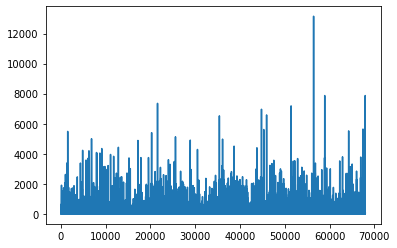

In [51]:
# Eyeballing and reviewing the length of keyword column for all rows 
# and visualizing the same by plotting.
df_final["len"] = df_final["keywords"].str.len()
df_final["len"].plot();

In [52]:
# Importing and initializing TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiating new default Tfid Vectorizer.
tfidf_vectorizer = TfidfVectorizer()

In [53]:
# Instantiating Tfid Vectorizer with ngram_range and min_df.
tfidf_vectorizer_with_hyperparams = TfidfVectorizer(ngram_range=(2,2), min_df=3)

In [54]:
# Calling Fit and Transform
basic_tfidf = tfidf_vectorizer.fit_transform(df_final["keywords"])
hyperparams_tfidf = tfidf_vectorizer_with_hyperparams.fit_transform(df_final["keywords"])

In [55]:
# Printing shape for TFID Vectorizer
print("Shape for basic TFID")
print(basic_tfidf.get_shape())
print("Shape for Hyperparams based TFID")
print(hyperparams_tfidf.get_shape())

Shape for basic TFID
(61225, 38369)
Shape for Hyperparams based TFID
(61225, 75073)


### 5.7 Segregate the data into dependent (sentiment) and independent (transformed body using tf-idf) features for building a classifier. 

In [56]:
# Creating dependent(y varible) df. 
y = df_final["sentiment"]

# Print shape for y dataframe.
print('y df shape', y.shape)

y df shape (61225,)


### 5.9 Split the data into Train & Test Sets

In [57]:
# Importing train_test_split from sklearn model_selection.
from sklearn.model_selection import train_test_split

# Train test split for basic Tfid.
X1_train, X1_test, y1_train, y1_test = train_test_split(basic_tfidf, y, random_state = 50, stratify=y, test_size=0.3)
# Train test split for hyper params based Tfid.
X2_train, X2_test, y2_train, y2_test = train_test_split(hyperparams_tfidf, y, random_state = 50, stratify=y, test_size=0.3)

As we can see above we have created two different set of Train and Test Dataframe, One we basic TF-IDF features data and the other with HyperParams TF-IDF features dataframe. We will be building two different model with their own respective set and see the comparision between to dataframe.

## 6. Model building


### 6.1 Build a random forest classifier to predict the 'sentiment'

In [58]:
# Import Random Forest Classifier from sklearn ensamble
from sklearn.ensemble import RandomForestClassifier

# Import Confusion Matrix from sklearn metrix.
from sklearn.metrics import confusion_matrix

Improting required libraries for building model and for confusion matrix.

In [59]:
# Creating instance of random forest classifier
rf_clf1 = RandomForestClassifier()

# Calling fit by passing set one of data.
rf_clf1.fit(X1_train, y1_train)

# Printing Train and Test score for rf_clf1.
print("Train Score for basic Tfid:")
print(rf_clf1.score(X1_train, y1_train))
print("Test Score for basic Tfid: ")
print(rf_clf1.score(X1_test, y1_test))

Train Score for basic Tfid:
0.9958699862332875
Test Score for basic Tfid: 
0.8877939895470384


With basic TF-IDF feature data and using random forest classifier we are able to get score of 99.5 on train data and score of 88.7 on test data. The figures suggest we have over fit model, but at same time with some tunnig we can achive better results.

In [60]:
# Creating another instance of random forest classifier second set of data.
rf_clf2 = RandomForestClassifier()

# Calling fit by passing second set of data.
rf_clf2.fit(X2_train, y2_train)

# Printing Train and Test score for rf_clf2.
print("Train Score for hyperparam Tfid:")
print(rf_clf2.score(X2_train, y2_train))
print("Test Score for hyperparam Tfid:")
print(rf_clf2.score(X2_test, y2_test))

Train Score for hyperparam Tfid:
0.9857199523998413
Test Score for hyperparam Tfid:
0.849520905923345


Above code uses hyperparams based TF-IDF feature data and using random forest classifier. The score we are gettting is 98.5 on train data and score of 84.8 on test data. The figures suggest we have over fit model, and also little less than the previous model..

### 6.2 Predict on test set

In [61]:
# Predict y for X1-train and X1-test using rf_clf1. 
# Store the predicted results y1_train_pred and y1_test_pred.
y1_train_pred = rf_clf1.predict(X1_train)
y1_test_pred = rf_clf1.predict(X1_test)

# Predict y for X2-train and X2-test using rf_clf2. 
# Store the predicted results y2_train_pred and y2_test_pred.
y2_train_pred = rf_clf2.predict(X2_train)
y2_test_pred = rf_clf2.predict(X2_test)

Above code does the predition for X1_Train, X1_Test, X2_Train and X2_Test dataframes and store the predictions results in y1_train_pred, y1_test_pred, y2_train_pred and y2_test_pred respectively. We will be using the predictions results with the corrosponding y in next statement to generate confusion matrix.

### 6.3 Check accuracy and confusion matrix

In [62]:
# Confusion matrix for set one train data.
confusion_matrix(y1_train, y1_train_pred)

array([[12637,   163],
       [   14, 30043]])

In [63]:
# Confusion matrix for set one test data.
confusion_matrix(y1_test, y1_test_pred)

array([[ 4055,  1431],
       [  630, 12252]])

As we can see from above confusion matrix the FP's and FN's increase many folds from train data to test data, Which clearly indicate the model is overfit.  

In [64]:
# Confusion matrix for second set train data.
confusion_matrix(y2_train, y2_train_pred)

array([[12200,   600],
       [   12, 30045]])

In [65]:
# Confusion matrix for second set test data.
confusion_matrix(y2_test, y2_test_pred)

array([[ 3379,  2107],
       [  657, 12225]])

Here also as seen in above above confusion matrix the FP's and FN's increase many folds from train data to test data, Which clearly indicate the model is overfit. 

## 7. Write your conclusion

Summary 

We have Convert a collection of raw documents to a matrix of TF-IDF features. Also we have generated two TF-IDF instances, one without any parameters where as other with couple of parameters. First instance of TF IDF has extrated 38369 features where as the scecond TF IDF has extracted 75073 features. Using these feature we have created two instances of Random Forest Classifier and below is our findings:

1) Both Random Forest classifier's models genrated are overfitted, which are performing good for train sets but poorly on test sets.

2) Number of rows for positive reviews are many fold more than the negitive reviews. We can balance out the classes by dropping some of the positive reviews or collect more samples for negitive classes. Also try different algorithms and generate synthetic samples to balance out classes or get better performance.

3) Also to improve predictions we can rely on features redution where as we can add some custom words to stop-words, use lemmitization for clubbing similar words, remove rare and most commonly used tokens. This will increase overall performance of the model.

4) Try different combinations of hyper-parameters and do model tunning.

5) Also we can take Xiaomi and Samsung out and try them seperately.

##. 8. Further Explore
### 8.0 Merge all independent features and the below text preprocessing steps
### 8.1 Check rare words and drop them
### 8.2 Remove emoticon/emojis
### 8.3 Try different vectorizer for vectorization
### 8.4 Use embeddings
### 8.5 Use NN based models